**id** (int64): Identifier.

**Gender** (object): Gender.

**Age** (float64): Age.

**Height** (float64): Height.

**Weight** (float64): Weight.

**family_history_with_overweight** (object): Family member suffered or suffers from overweight.

**FAVC** (object): Frequent consumption of high caloric food.

**FCVC** (float64): Frequency of consumption of vegetables.

**NCP** (float64): Number of main meals.

**CAEC** (object): Consumption of food between meals.

**SMOKE** (object): Smoker or not.

**CH2O** (float64): Consumption of water daily.

**SCC** (object): Calories consumption monitoring.

**FAF** (float64): Physical activity frequency.

**TUE** (float64): Time using technology devices.

**CALC** (object): Consumption of alcohol.

**MTRANS** (object): Transportation used

**NObeyesdad** (object): Obesity level deducted.

In [2]:
import pandas as pd
pd.options.display.max_columns=1000
pd.options.display.max_rows=1000

import optuna
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import clone

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [3]:
train=pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (20758, 18)
The dimension of the test dataset is: (13840, 17)


In [4]:
TARGET = 'NObeyesdad'

In [5]:
train.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [6]:
test.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS'],
      dtype='object')

In [7]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [8]:
train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [9]:
test.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          13840 non-null  object 
 1   Age                             13840 non-null  float64
 2   Height                          13840 non-null  float64
 3   Weight                          13840 non-null  float64
 4   family_history_with_overweight  13840 non-null  object 
 5   FAVC                            13840 non-null  object 
 6   FCVC                            13840 non-null  float64
 7   NCP                             13840 non-null  float64
 8   CAEC                            13840 non-null  object 
 9   SMOKE                           13840 non-null  object 
 10  CH2O                            13840 non-null  float64
 11  SCC                             13840 non-null  object 
 12  FAF                             

In [12]:
col_float = test.select_dtypes(include=['float64']).columns

print(f'Names: {list(col_float)}\nLen: {len(col_float)}')

Names: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Len: 8


In [13]:
col_object = test.select_dtypes(include=['object']).columns

len_object = len(col_object)

print(f'Names: {list(col_object)}\nLen: {len_object}')

Names: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Len: 8


In [14]:
train[train['NObeyesdad'] == 'Insufficient_Weight']['Gender'].value_counts()

Gender
Female    1621
Male       902
Name: count, dtype: int64

In [15]:
train['Gender'].value_counts()

Gender
Female    10422
Male      10336
Name: count, dtype: int64

In [16]:
sort_train = train.sort_values('NObeyesdad')

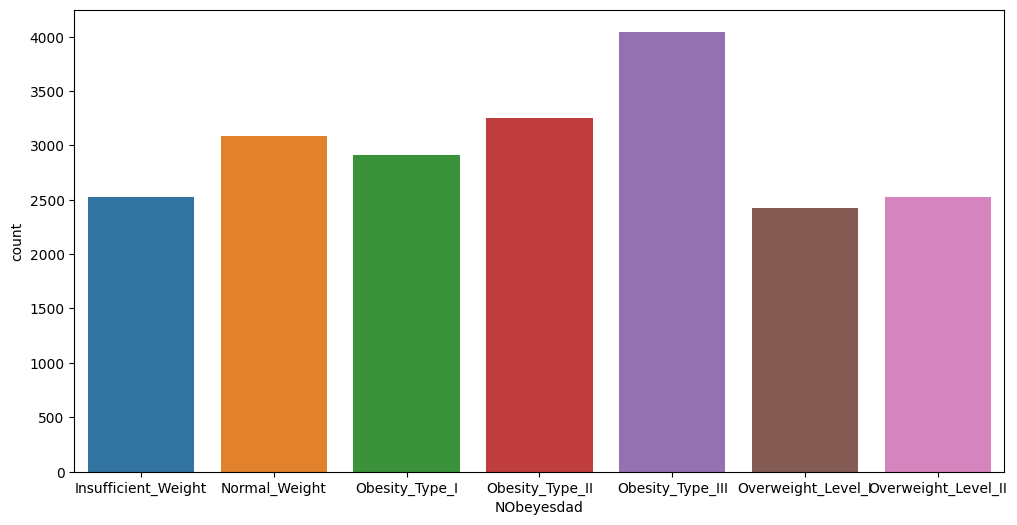

In [17]:
plt.rcParams["figure.figsize"] = [12, 6]
sns.countplot(x="NObeyesdad", data=sort_train);

# Analyzing categorical features

## MTRANS

In [18]:
round(train.groupby('NObeyesdad')['MTRANS'].value_counts(normalize=True)*100, 2).values

array([8.585e+01, 1.098e+01, 2.930e+00, 1.600e-01, 8.000e-02, 8.323e+01,
       1.003e+01, 5.740e+00, 5.500e-01, 4.500e-01, 7.326e+01, 2.567e+01,
       8.600e-01, 1.400e-01, 7.000e-02, 7.063e+01, 2.906e+01, 1.800e-01,
       9.000e-02, 3.000e-02, 1.000e+02, 7.561e+01, 1.957e+01, 4.160e+00,
       3.700e-01, 2.900e-01, 6.538e+01, 3.101e+01, 3.330e+00, 1.600e-01,
       1.200e-01])

In [19]:
to_analyze = train.groupby('NObeyesdad')['MTRANS'].value_counts().to_frame()
to_analyze['percentages'] = round(train.groupby('NObeyesdad')['MTRANS'].value_counts(normalize=True)*100, 2).values
to_analyze

count  percentages
NObeyesdad          MTRANS                                   
Insufficient_Weight Public_Transportation   2166        85.85
                    Automobile               277        10.98
                    Walking                   74         2.93
                    Motorbike                  4         0.16
                    Bike                       2         0.08
Normal_Weight       Public_Transportation   2565        83.23
                    Automobile               309        10.03
                    Walking                  177         5.74
                    Motorbike                 17         0.55
                    Bike                      14         0.45
Obesity_Type_I      Public_Transportation   2132        73.26
                    Automobile               747        25.67
                    Walking                   25         0.86
                    Motorbike                  4         0.14
                    Bike                       2         0.07
Obesity_Type_II     Public_Transportation   2294        70.63
                    Automobile               944        29.06
                    Walking                    6         0.18
                    Motorbike                  3         0.09
                    Bike                       1         0.03
Obesity_Type_III    Public_Transportation   4046       100.00
Overweight_Level_I  Public_Transportation   1835        75.61
                    Automobile               475        19.57
                    Walking                  101         4.16
                    Bike                       9         0.37
                    Motorbike                  7         0.29
Overweight_Level_II Public_Transportation   1649        65.38
                    Automobile               782        31.01
                    Walking                   84         3.33
                    Bike                       4         0.16
                    Motorbike                  3         0.12

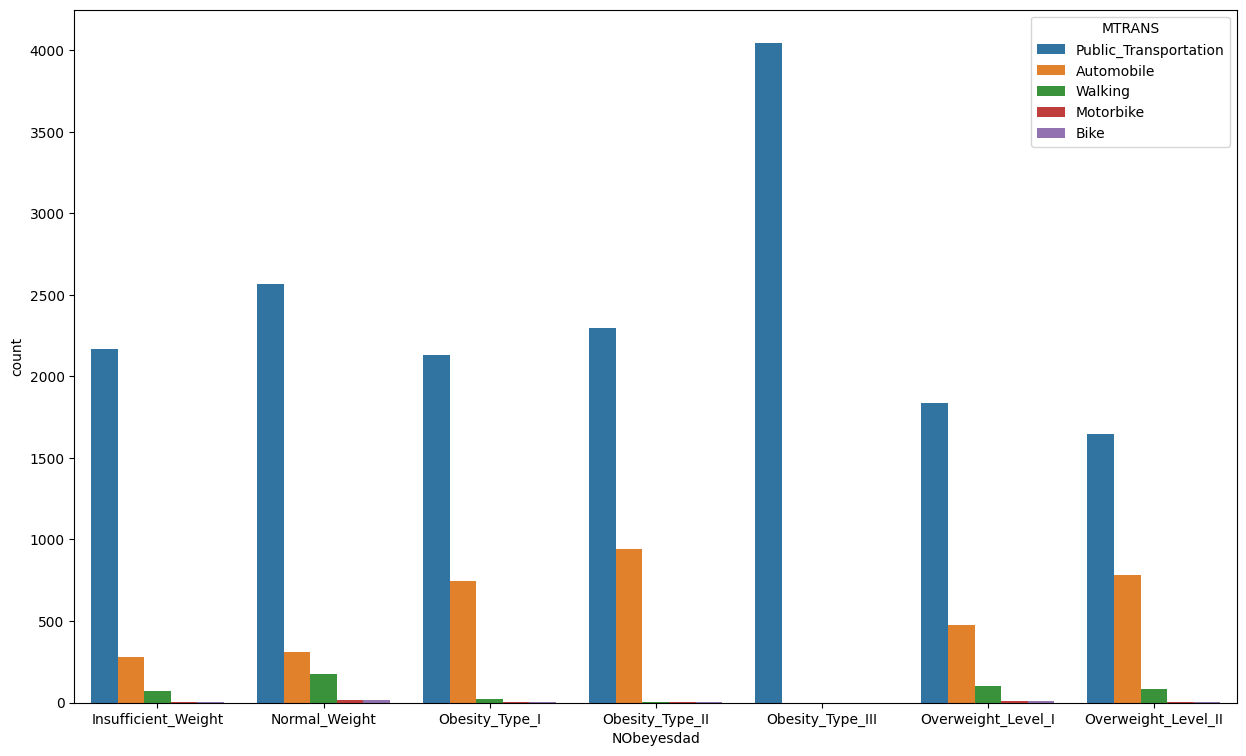

In [20]:
plt.rcParams["figure.figsize"] = [15, 9]
sns.countplot(x="NObeyesdad", hue="MTRANS", data=sort_train);

**People with older adults are more likely to travel by car**

Люди с ожерение чаще передвигаются на автомобиле

## CALC

In [21]:
round(train.groupby('Gender')['CALC'].value_counts(normalize=True).to_frame()*100,2)

proportion
Gender CALC                  
Female Sometimes        76.08
       no               22.24
       Frequently        1.68
Male   Sometimes        69.05
       no               27.53
       Frequently        3.42

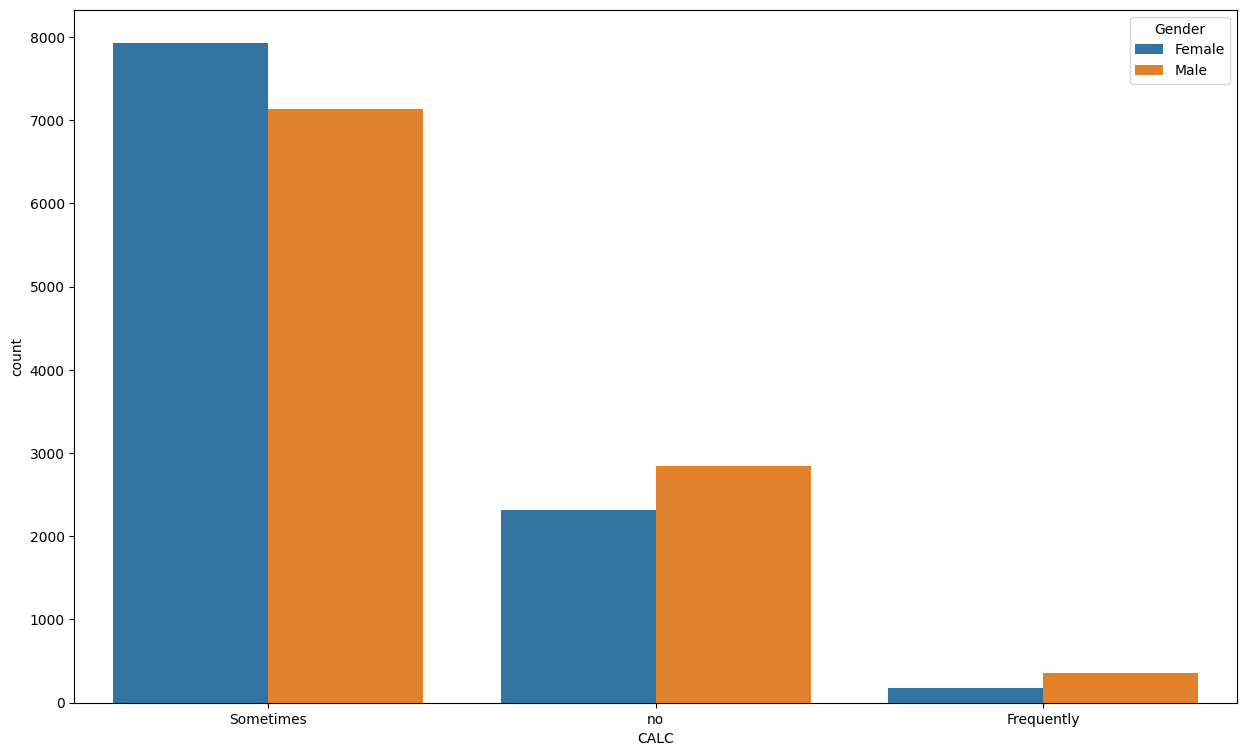

In [22]:
plt.rcParams["figure.figsize"] = [15, 9]
sns.countplot(x="CALC", hue="Gender", data=sort_train);

## SCC

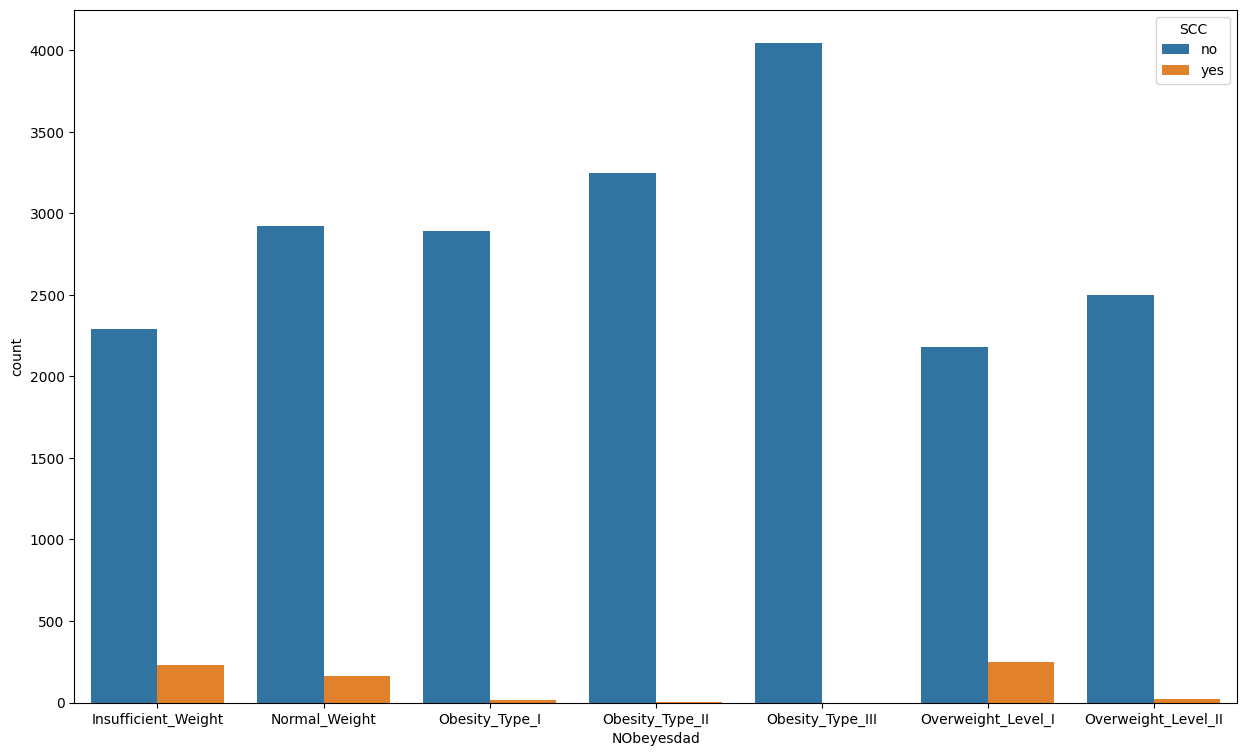

In [23]:
plt.rcParams["figure.figsize"] = [15, 9]
sns.countplot(x="NObeyesdad", hue="SCC", data=sort_train);

**Obese people don't have calorie monitoring**

У людей с ожирением нет мониторинга колорий

## SMOKE

In [24]:
round(train.groupby('SMOKE')['NObeyesdad'].value_counts(normalize=True).to_frame()*100,2)

proportion
SMOKE NObeyesdad                     
no    Obesity_Type_III          19.70
      Obesity_Type_II           15.28
      Normal_Weight             14.80
      Obesity_Type_I            14.07
      Insufficient_Weight       12.27
      Overweight_Level_II       12.17
      Overweight_Level_I        11.71
yes   Obesity_Type_II           46.53
      Normal_Weight             18.78
      Overweight_Level_I        10.20
      Overweight_Level_II       10.20
      Obesity_Type_I             9.80
      Insufficient_Weight        2.86
      Obesity_Type_III           1.63

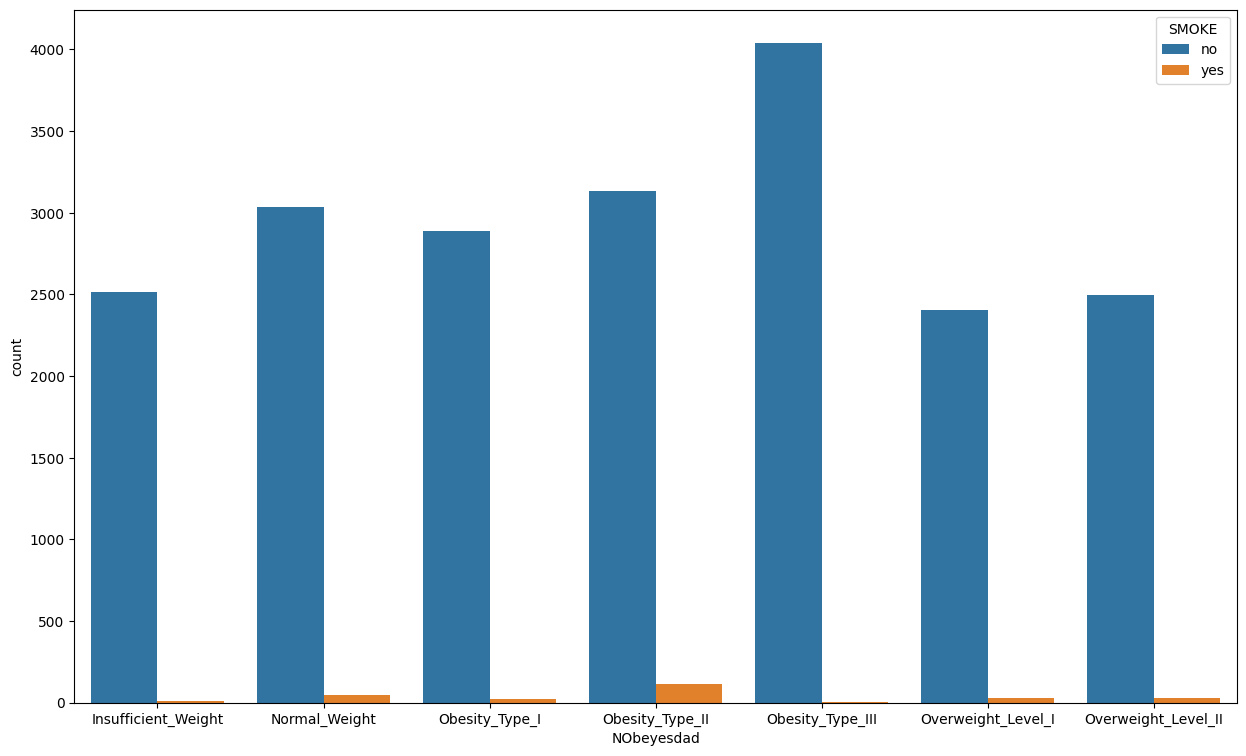

In [25]:
plt.rcParams["figure.figsize"] = [15, 9]
sns.countplot(x="NObeyesdad", hue="SMOKE", data=sort_train);

**I don't get it**

Не понятно 

## CAEC

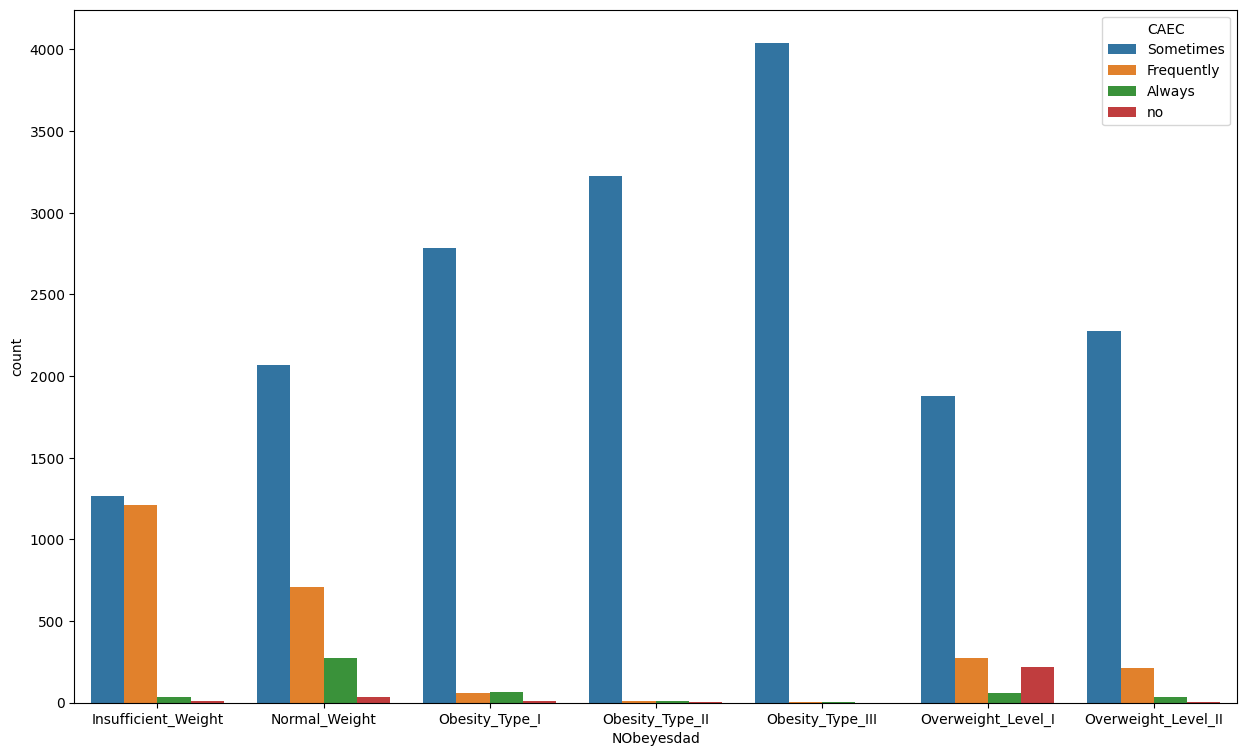

In [26]:
plt.rcParams["figure.figsize"] = [15, 9]
sns.countplot(x="NObeyesdad", hue="CAEC", data=sort_train);

**Obese people are embarrassed to evaluate themselves objectively**

Видимо, люди с ожирением стесняются себя объективно оценивать :)

### FAVC

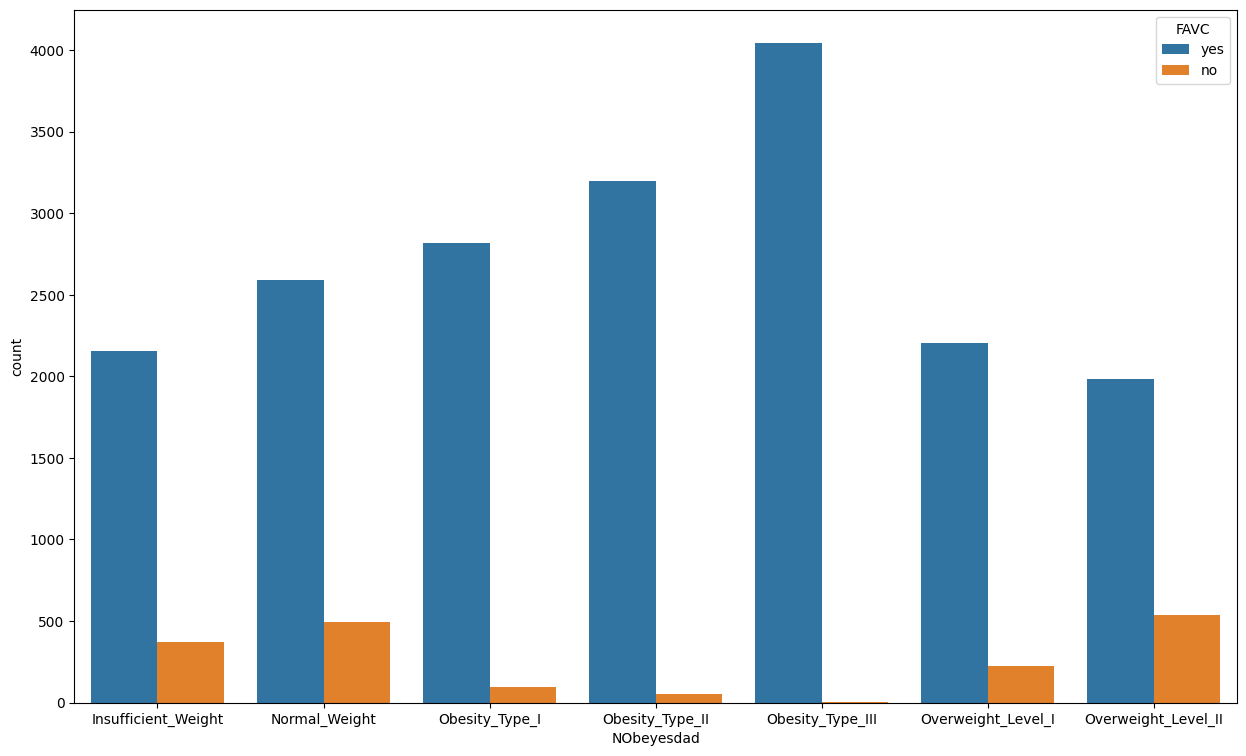

In [27]:
plt.rcParams["figure.figsize"] = [15, 9]
sns.countplot(x="NObeyesdad", hue="FAVC", data=sort_train);

**People with stage 1, 2, and 3 obesity have decreased athletic activity**

У людей с 1, 2 и 3 стадией ожирения спортивная активность уменьшается

## family_history_with_overweight

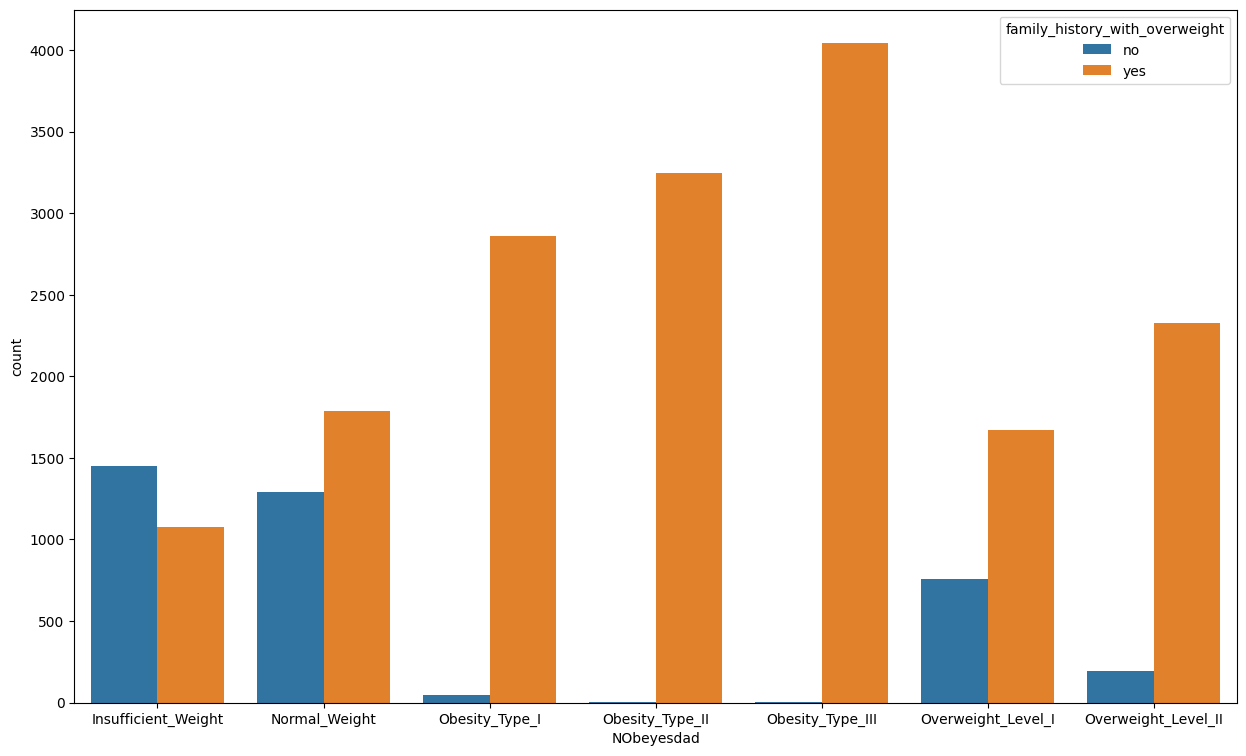

In [28]:
plt.rcParams["figure.figsize"] = [15, 9]
sns.countplot(x="NObeyesdad", hue="family_history_with_overweight", data=sort_train);

**If parents are obese, people are more likely to be obese**

Если родители страдают от ожирения, у людей повышается вероятность ожирения

# Analyzing numerical features

In [29]:
print(f'Names: {list(col_float)}\nLen: {len(col_float)}')

Names: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Len: 8


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

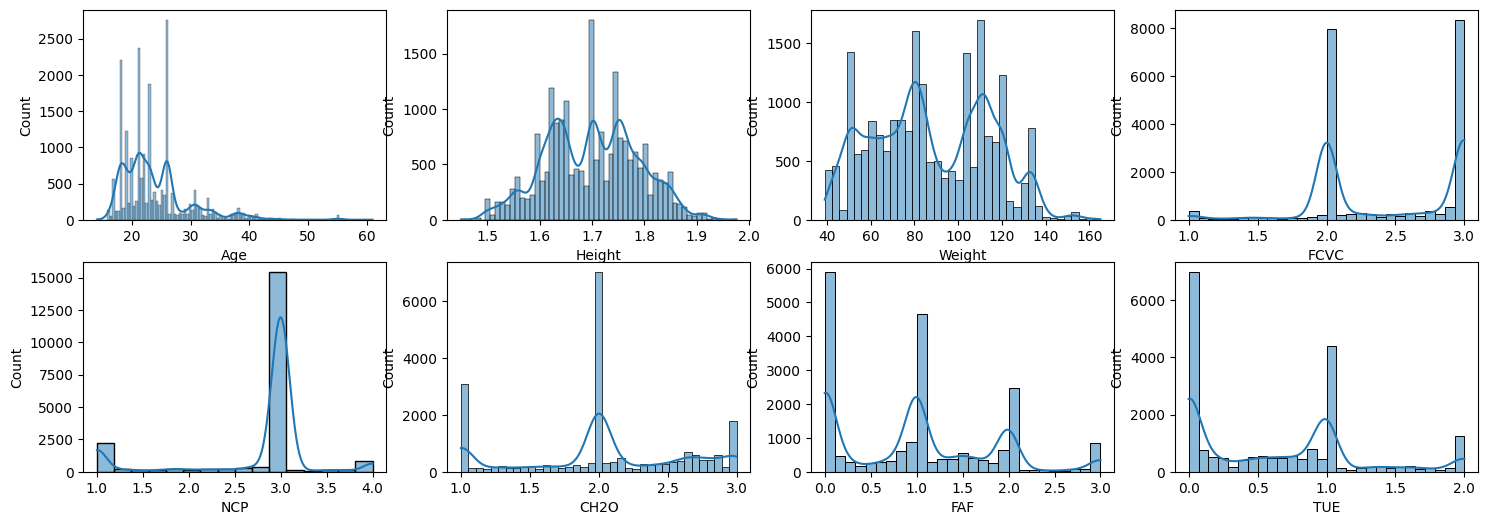

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(18, 6))


for i, name in enumerate(col_float):
    ax = axes[i//4, i%4]
    sns.histplot(data=train, x=name, ax=ax, kde=True)

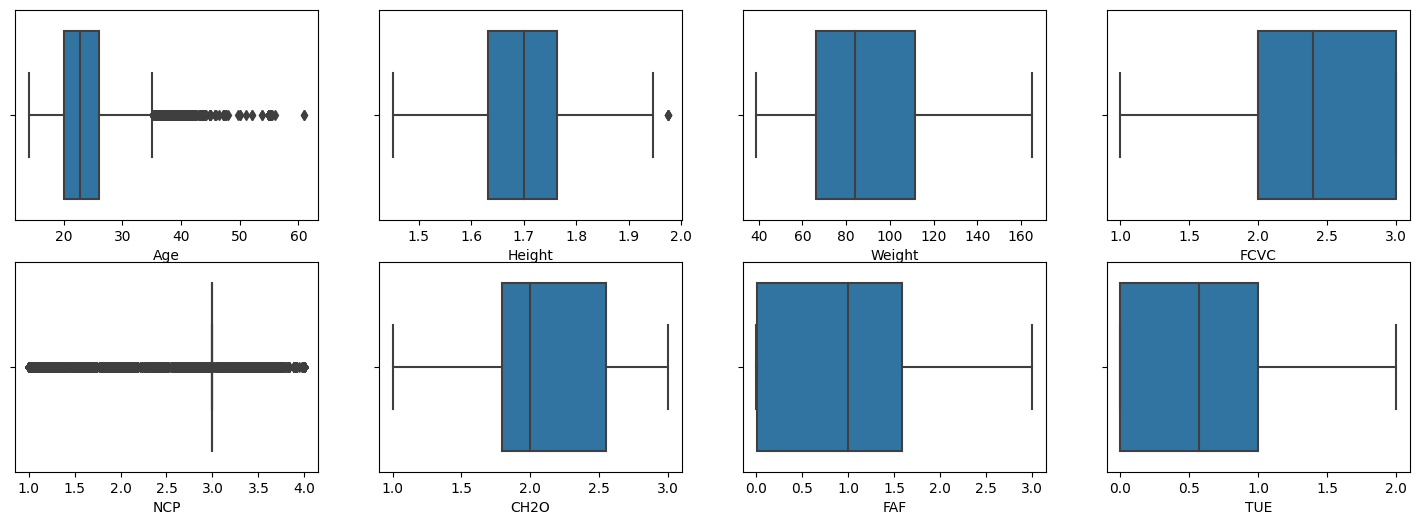

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(18, 6))

for i, name in enumerate(col_float):
    ax = axes[i//4, i%4]
    sns.boxplot(train, x=name, ax=ax);

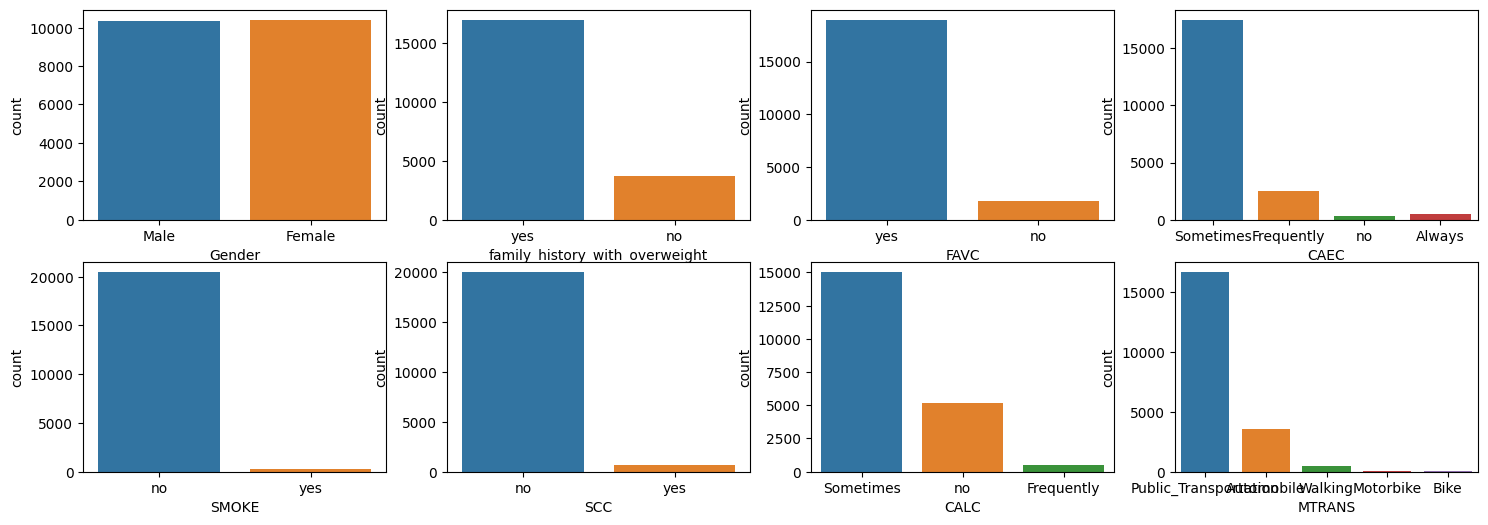

In [32]:
fig, axes = plt.subplots(2, 4, figsize=(18, 6))

for i, name in enumerate(col_object):
    ax = axes[i//4, i%4]
    sns.countplot(train, x=name, ax=ax)

# Preprocessin

**Body mass index**

Severe Thinness < 16

Moderate Thinness 16 - 17

Mild Thinness 17 - 18.5

Normal 18.5 - 25

Overweight 25 - 30

Obese Class I 30 - 35

Obese Class II 35 - 40

Obese Class III > 40

In [33]:
# BMI - body mass index. https://www.calculator.net/bmi-calculator.html
class BMIBinning(BaseEstimator, TransformerMixin):    
    def fit(self, y=None):
        return self
    
    def calc_bmi_categor(self, df):
        bmi = df['Weight']/(df['Height']**2)
        if bmi < 18.5:
            return 0 # 'Insufficient_Weight'
        elif bmi >= 18.5 and bmi < 25:
            return 1 # 'Normal_Weight'
        elif bmi >= 25 and bmi < 30:
            return 2 # 'Overweight'
        elif bmi >= 30 and bmi < 35:
            return 3 #'Obesity_Type_I'
        elif bmi >= 35 and bmi < 40:
            return 4 # 'Obesity_Type_II'
        else:
            return 5 # 'Obesity_Type_III'
    
#     def calc_bmi(self, df):
#         return df['Weight']/(df['Height']**2)

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['BMI'] = X_copy.apply(self.calc_bmi_categor, axis=1)
        return X_copy
        
BMIBinning().fit_transform(train)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,2
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,1
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,0
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,5
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,4
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,0
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,3
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II,2


In [34]:
class AgeFafBinning(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['age_faf'] = X_copy['Age'] * X_copy['FAF']
        return X_copy
        
AgeFafBinning().fit_transform(train)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,age_faf
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,0.000000
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,18.000000
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,15.588810
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,30.755747
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,62.268793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,33.445372
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,36.000000
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,23.277792
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II,0.000000


In [35]:
# Calculate lifestyle score
class CLSBinning(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def calculate_lifestyle_score(self, df):
        favc_score = 0 if df['FAVC'] == 'No' else 1  
        fcvc_score = df['FCVC']  
        faf_score = df['FAF']  
        tue_score = 1 if df['TUE'] > 2 else 0 
        return favc_score - fcvc_score + tue_score - faf_score
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        
        X_copy['lifestyle_score'] = X_copy.apply(self.calculate_lifestyle_score, axis=1)
        return X_copy
        
CLSBinning().fit_transform(train)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,lifestyle_score
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,-1.000000
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,-2.000000
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,-1.746579
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,-3.467863
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,-3.647637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,-3.250103
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,-4.000000
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,-2.565857
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II,-1.671238


In [36]:
# Health awareness score
class HASBinning(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def calculate_health_awareness_score(self, df):
        scc_score = 0 if df['SCC'] == 'No' else 1  
        ch2o_score = df['CH2O']  
        smoke_score = 1 if df['SMOKE'] == 'yes' else 0 
        return scc_score + ch2o_score + smoke_score
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['lifestyle_score'] = X_copy.apply(self.calculate_health_awareness_score, axis=1)
        return X_copy
        
HASBinning().fit_transform(train)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,lifestyle_score
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,3.763573
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,3.000000
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,2.910378
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,2.674061
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,2.979848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,3.151809
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,2.000000
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,3.000000
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II,3.144838


In [37]:
# Label Encoder
class CategoricalBinning(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = LabelEncoder().fit_transform(X_copy[col])
        return X_copy
        
col_object = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS']
CategoricalBinning(col_object).fit_transform(train)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,2,0,2.763573,0,0.000000,0.976473,1,3,Overweight_Level_II
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,1,0,2.000000,0,1.000000,1.000000,2,0,Normal_Weight
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,2,0,1.910378,0,0.866045,1.673584,2,3,Insufficient_Weight
3,0,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,2,0,1.674061,0,1.467863,0.780199,1,3,Obesity_Type_III
4,1,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,2,0,1.979848,0,1.967973,0.931721,1,3,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,1,25.137087,1.766626,114.187096,1,1,2.919584,3.000000,2,0,2.151809,0,1.330519,0.196680,1,3,Obesity_Type_II
20754,1,18.000000,1.710000,50.000000,0,1,3.000000,4.000000,1,0,1.000000,0,2.000000,1.000000,1,3,Insufficient_Weight
20755,1,20.101026,1.819557,105.580491,1,1,2.407817,3.000000,2,0,2.000000,0,1.158040,1.198439,2,3,Obesity_Type_II
20756,1,33.852953,1.700000,83.520113,1,1,2.671238,1.971472,2,0,2.144838,0,0.000000,0.973834,2,0,Overweight_Level_II


In [38]:
test.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS'],
      dtype='object')

In [39]:
col_category = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS']

col_number = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# pipe = Pipeline([
#     ('bmi', BMIBinning()),
#     ('age_faf', AgeFafBinning()),
#     ('cls', CLSBinning()),
#     ('has', HASBinning()),
#     ('categorical', CategoricalBinning(col_category))])

# pipe = pipe.fit(test)
# prep_train = pipe.transform(train)
# prep_test = pipe.transform(test)

col_transformer  = ColumnTransformer(
        transformers=[('num', StandardScaler(), col_number),
                      ('cat', OneHotEncoder(handle_unknown="ignore"), col_object)
                     ])

pipe = Pipeline([
    ('preproc', col_transformer)
])

pipe = pipe.fit(test)
prep_train = pd.DataFrame(pipe.transform(train), columns=pipe.get_feature_names_out())
prep_test = pd.DataFrame(pipe.transform(test), columns=pipe.get_feature_names_out())

In [40]:
prep_train

,num__Age,num__Height,num__Weight,num__FCVC,num__NCP,num__CH2O,num__FAF,num__TUE,cat__Gender_Female,cat__Gender_Male,cat__family_history_with_overweight_no,cat__family_history_with_overweight_yes,cat__FAVC_no,cat__FAVC_yes,cat__CAEC_Always,cat__CAEC_Frequently,cat__CAEC_Sometimes,cat__CAEC_no,cat__SMOKE_no,cat__SMOKE_yes,cat__SCC_no,cat__SCC_yes,cat__CALC_Always,cat__CALC_Frequently,cat__CALC_Sometimes,cat__CALC_no,cat__MTRANS_Automobile,cat__MTRANS_Bike,cat__MTRANS_Motorbike,cat__MTRANS_Public_Transportation,cat__MTRANS_Walking
0,0.084535,0.011987,-0.218857,-0.833161,0.327312,1.196859,-1.159701,0.601069,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.026405,-1.565324,-1.163672,-0.833161,0.350808,-0.052428,0.030307,0.639766,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,-1.026405,0.141125,-1.425412,-1.057896,-1.883420,-0.199059,-0.129101,1.747665,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.517277,0.132901,1.680922,1.047997,0.350808,-0.585698,0.587067,0.278241,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.325667,2.425172,0.245628,0.445395,-1.095987,-0.085398,1.182202,0.527462,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,0.204212,0.762662,1.026492,0.896722,0.350808,0.195948,0.423627,-0.681520,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
20754,-1.026405,0.124676,-1.431760,1.047997,1.757473,-1.688533,1.220314,0.639766,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
20755,-0.664134,1.359018,0.696874,-0.065993,0.350808,-0.052428,0.218375,0.966155,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
20756,1.707050,0.012009,-0.147999,0.429544,-1.095987,0.184543,-1.159701,0.596728,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [41]:
prep_test

,num__Age,num__Height,num__Weight,num__FCVC,num__NCP,num__CH2O,num__FAF,num__TUE,cat__Gender_Female,cat__Gender_Male,cat__family_history_with_overweight_no,cat__family_history_with_overweight_yes,cat__FAVC_no,cat__FAVC_yes,cat__CAEC_Always,cat__CAEC_Frequently,cat__CAEC_Sometimes,cat__CAEC_no,cat__SMOKE_no,cat__SMOKE_yes,cat__SCC_no,cat__SCC_yes,cat__CALC_Always,cat__CALC_Frequently,cat__CALC_Sometimes,cat__CALC_no,cat__MTRANS_Automobile,cat__MTRANS_Bike,cat__MTRANS_Motorbike,cat__MTRANS_Public_Transportation,cat__MTRANS_Walking
0,0.508163,1.682789,1.273786,0.932524,0.350808,1.298389,-0.141769,-1.005016,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.509128,-1.114658,-0.818988,-0.833161,-2.462523,1.583678,0.030307,-1.005016,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.353000,-0.626191,0.927432,1.047997,0.350808,0.965029,-1.159701,-0.592995,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.512705,-1.642760,0.623672,-0.833161,0.319733,1.234234,-1.046828,-1.005016,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.353000,-0.805996,0.668336,1.047997,0.350808,1.016818,-1.159701,0.213881,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,-0.107749,0.252936,-0.358246,0.696661,0.350808,-1.688533,-0.199274,0.275664,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
13836,0.870277,-1.227324,-0.972181,1.047997,0.350808,-0.052428,-1.159701,-1.005016,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
13837,-0.175379,-1.277495,-1.647125,1.047997,-0.670797,-0.052428,1.160623,0.639766,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
13838,-0.509128,-0.889324,-1.316865,-0.833161,0.350808,-0.052428,2.410322,2.284548,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [42]:
target_encode = {
    'Insufficient_Weight':0,
    'Normal_Weight':1,
    'Overweight_Level_I':2,
    'Overweight_Level_II':3,
    'Obesity_Type_I':4,
    'Obesity_Type_II':5 ,
    'Obesity_Type_III':6
}

target_decode = {
    0:'Insufficient_Weight',
    1:'Normal_Weight',
    2:'Overweight_Level_I',
    3:'Overweight_Level_II',
    4:'Obesity_Type_I',
    5:'Obesity_Type_II' ,
    6:'Obesity_Type_III'
}

prep_train[TARGET] = train[TARGET].map(target_encode)

In [43]:
prep_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   num__Age                                 20758 non-null  float64
 1   num__Height                              20758 non-null  float64
 2   num__Weight                              20758 non-null  float64
 3   num__FCVC                                20758 non-null  float64
 4   num__NCP                                 20758 non-null  float64
 5   num__CH2O                                20758 non-null  float64
 6   num__FAF                                 20758 non-null  float64
 7   num__TUE                                 20758 non-null  float64
 8   cat__Gender_Female                       20758 non-null  float64
 9   cat__Gender_Male                         20758 non-null  float64
 10  cat__family_history_with_overweight_no   20758

In [44]:
feach_col = prep_test.columns

In [45]:
X, y, X_test= prep_train[feach_col], prep_train[TARGET], prep_test[feach_col]

# Modeling

In [57]:
skf = StratifiedKFold(n_splits=5)

def cross_val_model(estimators,cv = skf, verbose = True):
    test_predictions = np.zeros((len(test),7))
    valid_predictions = np.zeros((len(X),7))

    val_scores, train_scores = [],[]
    for fold, (train_ind, valid_ind) in enumerate(skf.split(X,y)):
        model = clone(estimators)
        #define train set
        X_train = X.iloc[train_ind]
        y_train = y.iloc[train_ind]
        #define valid set
        X_valid = X.iloc[valid_ind]
        y_valid = y.iloc[valid_ind]

        model.fit(X_train, y_train)
        if verbose:
            print(f"Fold: {fold}", end=' ')
            print(f"Train Acc: {accuracy_score(y_true=y_train,y_pred=model.predict(X_train))}", end=' ')
            print(f"Valid Acc: {accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid))}")

        
        test_predictions += model.predict_proba(X_test)/cv.get_n_splits()
        valid_predictions[valid_ind] = model.predict_proba(X_valid)
        val_scores.append(accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid)))
    acc_score = np.array(val_scores).mean()
    if verbose: 
        print(f"Average Mean Accuracy Score: {acc_score}")
    return val_scores, valid_predictions, test_predictions

In [47]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

## Selection of hyperparameters

In [48]:
# def LGBMobjective(trial):
    
#     param = {
#         'n_estimators' : trial.suggest_int('n_estimators',50,500),
#         "max_depth":trial.suggest_int('max_depth',3,50),
#         "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
#         "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
#         "min_child_samples" : trial.suggest_int('min_child_samples',1,100),
#         "subsample" : trial.suggest_float('subsample', 0.4, 1),
#         "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
#         "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
#         'num_leaves' : trial.suggest_int('num_leaves', 2, 64),
#         "random_state": 42,
#         'objective':'multiclass', 
#         'force_col_wise':True, 
#         'verbose':-1,
#         'device_type' : "gpu",
#     }

#     # Initialize and train the model
#     model = LGBMClassifier(**param)

#     # Perform cross-validation
#     score = cross_val_score(model, np.array(X), y, scoring='accuracy', cv=5, n_jobs=-1).mean()
#     print("The Accuracy: ", score)
    
#     model.fit(np.array(X), y)
    
#     return score

# # Enable Optuna's progress bar
# optuna.logging.set_verbosity(optuna.logging.INFO)

# lgb_study = optuna.create_study(direction='maximize')
    
# # Start the optimization process
# lgb_study.optimize(LGBMobjective, n_trials=50, show_progress_bar=True)




# best_trial = lgb_study.best_trial

# print("Best trial:")
# print(f"  Value (Accuracy): {best_trial.value}")

# print("Best hyperparameters:")
# for key, value in best_trial.params.items():
#     print(f"  {key}: {value}")

In [49]:
# def XGBobjective(trial):

    
#     param = {
#         'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'gamma' : trial.suggest_float('gamma', 1e-9, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.25, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
#         'max_depth': trial.suggest_int('max_depth', 0, 24),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
#         'use_label_encoder':False,
#         'random_state':42,
#         'booster':'gbtree',
#         'objective':'multi:softmax'
#     }

#     # Initialize and train the model
#     model = XGBClassifier(**param)

#     # Perform cross-validation
#     score = cross_val_score(model, np.array(X), y, scoring='accuracy', cv=5, n_jobs=-1).mean()
#     print("The Accuracy: ", score)
    
#     model.fit(np.array(X), y)
    
#     return score

# # Enable Optuna's progress bar
# optuna.logging.set_verbosity(optuna.logging.INFO)

# xgb_study = optuna.create_study(direction='maximize')
    
# # Start the optimization process
# xgb_study.optimize(XGBobjective, n_trials=50, show_progress_bar=True)


# best_trial = xgb_study.best_trial

# print("Best trial:")
# print(f"  Value (Accuracy): {best_trial.value}")

# print("Best hyperparameters:")
# for key, value in best_trial.params.items():
#     print(f"  {key}: {value}")

In [50]:
# def HGBobjective(trial):
    
#     param = {
#         'l2_regularization': trial.suggest_float('l2_regularization',1e-10,10.0),
#         'early_stopping': trial.suggest_categorical('early_stopping', [False]),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001,0.1),
#         'max_iter': trial.suggest_categorical('max_iter', [1000]),
#         'max_depth': trial.suggest_int('max_depth', 2,30),
#         'max_bins': trial.suggest_int('max_bins', 100,255),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20,100000),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20,80),
#     }

#     # Initialize and train the model
#     model = HistGradientBoostingClassifier(**param, random_state=42)

#     # Perform cross-validation
#     score = cross_val_score(model, np.array(X), y, scoring='accuracy', cv=5, n_jobs=-1).mean()
#     print("The Accuracy: ", score)
    
#     model.fit(np.array(X), y)
    
#     return score

# # Enable Optuna's progress bar
# optuna.logging.set_verbosity(optuna.logging.INFO)

# hgb_study = optuna.create_study(direction='maximize')
    
# # Start the optimization process
# hgb_study.optimize(HGBobjective, n_trials=50, show_progress_bar=True)

# best_trial = hgb_study.best_trial

# print("Best trial:")
# print(f"  Value (Accuracy): {best_trial.value}")

# print("Best hyperparameters:")
# for key, value in best_trial.params.items():
#     print(f"  {key}: {value}")


## Setting hyperparameters

In [51]:
lgb_params = {
    'n_estimators': 259,
    'max_depth': 36,
    'learning_rate': 0.09243920606832862,
    'reg_alpha': 3.295250312065604,
    'reg_lambda': 2.066753141787848,
    'min_child_weight': 2.8021891277903332,
    'min_child_samples': 69,
    'subsample': 0.7033855422970872,
    'subsample_freq': 0,
    'colsample_bytree': 0.347332732834626,
    'num_leaves': 52,
    'random_state': 42,
    'objective':'multiclass', 
    'force_col_wise':True, 
    'verbose':-1
}


xgb_param = {
    'grow_policy': 'lossguide',
    'n_estimators': 182,
    'learning_rate': 0.12165737750373193,
    'gamma': 0.7937908511813354,
    'subsample': 0.9351883015759059,
    'colsample_bytree': 0.4270260595772601,
    'max_depth': 22,
    'min_child_weight': 7,
    'reg_lambda': 1.4103226777980434e-06,
    'reg_alpha': 3.1511192545909444e-06,
    'use_label_encoder':False,
    'random_state':42,
    'booster':'gbtree',
    'objective':'multi:softmax'
}

hgb_param = {
    'l2_regularization': 8.215766843805097,
    'early_stopping': False,
    'learning_rate': 0.08976133008363996,
    'max_iter': 1000,
    'max_depth': 2,
    'max_bins': 229,
    'min_samples_leaf': 53,
    'max_leaf_nodes': 58
}

In [52]:
RANDOM_STATE = 5

lgb_model = LGBMClassifier(**lgb_params);
hgb_model = HistGradientBoostingClassifier(**hgb_param)
xgb_model = XGBClassifier(**xgb_param)

In [54]:
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [58]:
val_scores,val_predictions,test_predictions = cross_val_model(lgb_model,cv = skf)

for k,v in target_encode.items():
    oof_list[f"lgb_{k}"] = val_predictions[:,v]

for k,v in target_encode.items():
    predict_list[f"lgb_{k}"] = test_predictions[:,v]

Fold: 0 Train Acc: 0.9453209683247019 Valid Acc: 0.9053468208092486
Fold: 1 Train Acc: 0.9458027219077442 Valid Acc: 0.9051059730250481
Fold: 2 Train Acc: 0.9444778995543779 Valid Acc: 0.9147398843930635
Fold: 3 Train Acc: 0.9460468477148191 Valid Acc: 0.9130330040953987
Fold: 4 Train Acc: 0.9458059854278317 Valid Acc: 0.9135148157070585
Average Mean Accuracy Score: 0.9103480996059634


In [59]:
val_scores,val_predictions,test_predictions = cross_val_model(hgb_model,cv = skf)

for k,v in target_encode.items():
    oof_list[f"hgb_{k}"] = val_predictions[:,v]

for k,v in target_encode.items():
    predict_list[f"hgb_{k}"] = test_predictions[:,v]

Fold: 0 Train Acc: 0.9334577863422859 Valid Acc: 0.9029383429672447
Fold: 1 Train Acc: 0.9327351559677225 Valid Acc: 0.9041425818882466
Fold: 2 Train Acc: 0.9305672648440323 Valid Acc: 0.9111271676300579
Fold: 3 Train Acc: 0.9334015776479798 Valid Acc: 0.9077330763671404
Fold: 4 Train Acc: 0.9311736014933462 Valid Acc: 0.9118284750662491
Average Mean Accuracy Score: 0.9075539287837877


In [60]:
val_scores,val_predictions,test_predictions = cross_val_model(xgb_model,cv = skf)

for k,v in target_encode.items():
    oof_list[f"xgb_{k}"] = val_predictions[:,v]

for k,v in target_encode.items():
    predict_list[f"xgb_{k}"] = test_predictions[:,v]

Fold: 0 Train Acc: 0.9486932434059978 Valid Acc: 0.9079961464354528
Fold: 1 Train Acc: 0.9497169697699627 Valid Acc: 0.9072736030828517
Fold: 2 Train Acc: 0.9487534626038782 Valid Acc: 0.9157032755298651
Fold: 3 Train Acc: 0.9481543927259589 Valid Acc: 0.9094194170079499
Fold: 4 Train Acc: 0.949358704160896 Valid Acc: 0.9147193447362082
Average Mean Accuracy Score: 0.9110223573584655


In [61]:
skf = StratifiedKFold(n_splits=5)

tmp = oof_list.copy()
for k,v in target_encode.items():
    tmp[f"{k}"] = (tmp[f"lgb_{k}"] +
                   tmp[f"hgb_{k}"] +
                   tmp[f"xgb_{k}"])
tmp['pred'] = tmp[target_encode.keys()].idxmax(axis = 1)
tmp['label'] = train[TARGET]
print(f"Ensemble Accuracy Scoe: {accuracy_score(train[TARGET],tmp['pred'])}")

Ensemble Accuracy Scoe: 0.9118412178437229


In [ ]:
submission=pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

In [ ]:
for k,v in target_encode.items():
    predict_list[f"{k}"] = (predict_list[f"lgb_{k}"]+
                            predict_list[f"hgb_{k}"]+
                            predict_list[f"xgb_{k}"])

final_pred = predict_list[target_encode.keys()].idxmax(axis = 1)

submission['NObeyesdad'] = final_pred
submission.to_csv("submission.csv",index=False)